In [2]:
from IPython.display import display

from sympy import *
init_printing()

from monomial import *

In [3]:
t, x, tau, h, s0, s1, s = symbols(r't, x, tau, h, sigma_0, sigma_1, sigma', real=True)
f1, f2 = (f(t, x) for f in symbols(r'{\phi_1}, {\phi_2}', cls=Function))

In [4]:
pda_f, pda_v = (f1, f2), (t, x)
pda_n, pda_clp = (7, 7), (3, 3)
pda_p = Rational(1, 2), Rational(0, 1)

In [5]:
pda_var, pda_fun = Monom.init([str(v) for v in pda_v],\
                              [str(f) for f in pda_f])
pda_var = dict(zip(pda_v, pda_var))
pda_fun = dict(zip(pda_f, pda_fun))

In [6]:
def T(f, i1, j1):
    return sum(sum(\
        diff(f, t, i, x, j)*(tau*(i1 - pda_p[0]))**i \
                             *(h*(j1 - pda_p[1]))**j/\
                 (factorial(i)*factorial(j))\
        for i in range(pda_n[0]))\
        for j in range(pda_n[1]))

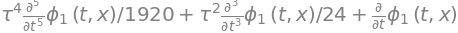

In [7]:
expand((T(f1, 1, 0) - T(f1, 0, 0))/(tau))

In [8]:
def clip(f):
    f = f.expand()
    r = []
    for i in range(pda_clp[0]):
        for j in range(pda_clp[1]):
            c = f.coeff(tau, i).coeff(h, j)
            if c and (\
            (pda_clp[0]-1 != i or j == 0) and \
            (pda_clp[1]-1 != j or i == 0)):
                r.append(((i, j), c))
    return r

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m.position()]
    for i in range(len(m)):
        r = r.diff(pda_v[i], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def mult(a, s):
    r = []
    for mc in a:
        m = mc[0][0] + s[0], mc[0][1] + s[1]
        if m[0] < pda_clp[0] and m[1] < pda_clp[1] and\
           (pda_clp[0]-1 != m[0] or m[1] == 0) and \
           (pda_clp[1]-1 != m[1] or m[0] == 0):
            r.append((m, mc[1]))
    return r

def add(a, b):
    r, ia, ib = [], 0, 0
    iaend, ibend = len(a), len(b)
    while ia < iaend and ib < ibend:
        ma, mb = a[ia][0], b[ib][0]
        if ma[0] > mb[0]:
            c = 1
        elif ma[0] < mb[0]:
            c = -1
        elif ma[1] > mb[1]:
            c = 1
        elif ma[1] < mb[1]:
            c = -1
        else:
            c = 0
        
        if c == -1:
            r.append(a[ia])
            ia += 1
        elif c == 1:
            r.append(b[ib])
            ib += 1
        else:
            d = expand(a[ia][1] + b[ib][1])
            if d:
                r.append((ma, d))
            ia += 1
            ib += 1
    while ia < iaend:
        r.append(a[ia])
        ia += 1
    while ib < ibend:
        r.append(b[ib])
        ib += 1
    return r

def reduction(f1, f2, m, c, shift):
#     print(m, c, shift)
    f = mult(f2, shift)
    if not m:
        f = [(s, c*p) for s, p in f]
    else:
        f = [(s, c*p.diff(*m)) for s, p in f]
    return add(f1, f)

def NF(f, df, G, head=False):
    assert len(df) == len(G)
    ms = [df2m(d) for d in df]
    i = 0 if head else 1
    while i < len(f):
        shift, p = f[i]
        while True:
            r = None
            for l in range(len(ms)):
                r = findDiv(p, ms[l])
                if r:
                    break
            if not r: 
                break
            m = m2df(r)
            deg = p.as_poly(m).degree()
            c = p.coeff(m, deg)
            if deg > 1:
                c = p.coeff(m, deg)*m**(deg - 1)
            m = r/ms[l]
            d = []
            for k in range(len(pda_v)):
                if m[k] > 0:
                    d.append(pda_v[k])
                    if m[k] > 1:
                        d.append(m[k])
            f = reduction(f, G[l], tuple(d), -c/G[l][0][1].coeff(df[l]), shift)
            if i == len(f):
                break
            shift, p = f[i]
        i += 1
    return f

def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in pda_f:
                return Symbol("%s" % a.func, real=True)
            elif a.func == Derivative:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return Symbol("%s_{%s}" % (a.args[0].func, "".join(m)), real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return cmpct(f)

def prn(a, p=None):
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += "tau"
            else:
                s += "tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += "h^%d" % m[1]
        if s:
            print("%s =>" % s)
        if p:
            display(compact(c).collect(p, factor))
        else:
            display(compact(c))

def prnlatex(a, p=None):
    first = True
    for m, c in a:
        s = ""
        if m[0]:
            if m[0] == 1:
                s += r"\tau"
            else:
                s += r"\tau^%d" % m[0]
        if m[1]:
            if m[0]:
                s += " "
            if m[1] == 1:
                s += "h"
            else:
                s += r"h^%d" % m[1]
        if s:
            if first:
                first = False
                print(r"%s\Big(" % s)
            else:
                print(r" + %s\Big(" % s)
        if p:
            print(latex(compact(c).collect(p, factor)))
        else:
            print(latex(compact(c)))
        if first:
            first = False
        else:
            print(r"\Big)") 

In [9]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)
def Dx(a):
    return ((T(a, 1, 1) - T(a, 1, -1))/(2*h) +\
            (T(a, 0, 1) - T(a, 0, -1))/(2*h))/2
def Dxxx(a):
    return ((T(a, 1, 2) - 2*T(a, 1, 1) + 2*T(a, 1, -1) - T(a, 1, -2))/(2*h**3) +\
            (T(a, 0, 2) - 2*T(a, 0, 1) + 2*T(a, 0, -1) - T(a, 0, -2))/(2*h**3))/2

In [10]:
Monom.cmp = Monom.TOPdeglex

In [11]:
F1 = clip(Dt(f1) + 3*s0*Dx(f1**2) + 2*s1*Dx(f1**3) + Dxxx(f1) +\
          (T(f1 - f2, 1, 0) + T(f1 - f2, 0, 0))/2)
prn(F1)
# prnlatex(F1)

h^2 =>


tau^2 =>


In [12]:
F2 = clip(Dt(f2) + 3*s0*Dx(f2**2) + 2*s1*Dx(f2**3) + Dxxx(f2) +\
          (T(f2 - f1 + s*f2, 1, 0) + T(f2 - f1 + s*f2, 0, 0))/2)
prn(F2)
# prnlatex(F2)

h^2 =>


tau^2 =>


In [13]:
F1fda = NF(F1, [f1.diff(x, 3), f2.diff(x, 3)], [F1, F2], head=False)
prn(F1fda)
# prnlatex(F1fda)
print(len(F1fda[1][1].args))
print(len(F1fda[2][1].args))

h^2 =>


tau^2 =>


15
2


In [14]:
F2fda = NF(F2, [f1.diff(x, 3), f2.diff(x, 3)], [F1, F2], head=False)
prn(F2fda)
# prnlatex(F2fda)
print(len(F2fda[1][1].args))
print(len(F2fda[2][1].args))

h^2 =>


tau^2 =>


18
2


In [15]:
D, k, xi = symbols('D, k, xi', real=True)

# Физически нелинейные соосные упругие цилиндрические оболочки, заполненные вязкой несжимаемой жидкостью, включая внутреннюю оболочку
\begin{equation}\label{Blin_eq7a}
  \begin{split}
    \phi_t^{(1)}&+6\sigma_0\phi^{(1)}\phi_\eta^{(1)}+\phi_{\eta\eta\eta}^{(1)}\mp
6\sigma_1{\phi^{(1)}}^2\phi_\eta^{(1)}+
      \phi^{(1)}-\phi^{(2)}=0,\\
    \phi_t^{(2)}&+6\sigma_0\phi^{(2)}\phi_\eta^{(2)}+\phi_{\eta\eta\eta}^{(2)}\mp
6\sigma_1{\phi^{(2)}}^2\phi_\eta^{(2)}+
      \phi^{(2)}-\phi^{(1)} - \sigma \phi^{(2)} =0,
  \end{split}
\end{equation}

# решение в виде солитона с пьедесталом, которое 
обобщает решение Слюняева--Пелиновскогопри $D=0$ 
\begin{equation}\label{Blin_eq72a}
\begin{gathered}
F = (\mp 2 D\,\sigma_1+\sigma_0), \\
 \phi^{(1)} = \phi^{(2)} = D + \frac{{k}^{2}}{F + \sqrt{F ^2\mp
 k^2\sigma_1}\,
\mathrm{cosh}\left(k \left[\eta - (6 D (\mp D\,\sigma_1+\sigma_0) + k^2) t\right]\right)} .
\end{gathered}
\end{equation} 

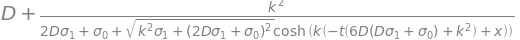

In [16]:
rp = {s: 0}
F = 2*D*s1 + s0
ex2 = D + k**2/(F + sqrt(F**2 + k**2*s1)*cosh(k*(x - (6*D*(D*s1 + s0) +  k**2)*t)))
# ex2m = ex2m.rewrite(tanh).expand().trigsimp()
display(ex2)
# print(latex(ex2).replace(r'k x', r'\xi').replace(r'- k^{2} + \left(- 2 D + \sigma_{0}\right)^{2}', r'\delta'))
display(F1fda[0][1].subs(rp)\
  .subs({f1: ex2, f2: ex2}).subs({t: 0}).doit().simplify())

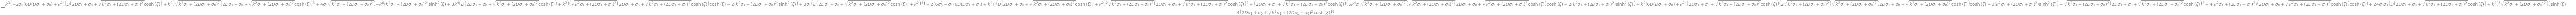

In [24]:
res = F1fda[1][1].subs(rp)\
  .subs({f1: ex2, f2: ex2}).doit().subs({x: xi/k + (6*D*(D*s1 + s0) +  k**2)*t}).simplify()
display(res)
# print(str(res).replace('sigma_', 's'))

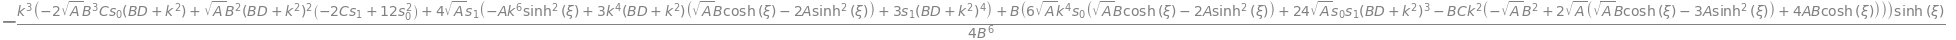

-k**3*(-2*sqrt(A)*B**3*C*s0*(B*D + k**2) + sqrt(A)*B**2*(B*D + k**2)**2*(-2*C*s1 + 12*s0**2) + 4*sqrt(A)*s1*(-A*k**6*sinh(xi)**2 + 3*k**4*(B*D + k**2)*(sqrt(A)*B*cosh(xi) - 2*A*sinh(xi)**2) + 3*s1*(B*D + k**2)**4) + B*(6*sqrt(A)*k**4*s0*(sqrt(A)*B*cosh(xi) - 2*A*sinh(xi)**2) + 24*sqrt(A)*s0*s1*(B*D + k**2)**3 - B*C*k**2*(-sqrt(A)*B**2 + 2*sqrt(A)*(sqrt(A)*B*cosh(xi) - 3*A*sinh(xi)**2) + 4*A*B*cosh(xi))))*sinh(xi)/(4*B**6)


In [25]:
res = sympify(str(res).replace('sigma_', 's').\
    replace('(6*D*(D*s1 + s0) + k**2)', 'C').\
    replace('(2*D*s1 + s0 + sqrt(k**2*s1 + (2*D*s1 + s0)**2)*cosh(xi))', 'B').\
    replace('sqrt(k**2*s1 + (2*D*s1 + s0)**2)', 'sqrt(A)').\
    replace('(4*k**2*s1 + 4*(2*D*s1 + s0)**2)', '4*A').\
    replace('(3*k**2*s1 + 3*(2*D*s1 + s0)**2)', '3*A').\
    replace('(2*k**2*s1 + 2*(2*D*s1 + s0)**2)', '2*A').\
    replace('(k**2*s1 + (2*D*s1 + s0)**2)', 'A'))
display(res)
# print(latex(res))
print(str(res).replace('sigma_', 's'))

In [27]:
sympify(str(res).replace('sigma_', 's').\
    replace('C', 'k**2').\
    replace('B', 'k').\
    replace('sqrt(A)', 'k').\
    replace('A', 'k**2')).expand()

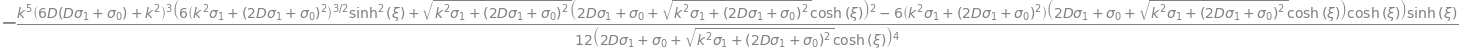

In [28]:
res = F1fda[2][1].subs(rp)\
  .subs({f1: ex2, f2: ex2}).doit().subs({x: xi/k + (6*D*(D*s1 + s0) +  k**2)*t}).simplify()
display(res)
# print(str(res).replace('sigma_', 's'))

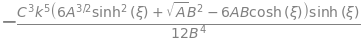

-C**3*k**5*(6*A**(3/2)*sinh(xi)**2 + sqrt(A)*B**2 - 6*A*B*cosh(xi))*sinh(xi)/(12*B**4)


In [29]:
res = sympify(str(res).replace('sigma_', 's').\
    replace('(6*D*(D*s1 + s0) + k**2)', 'C').\
    replace('(2*D*s1 + s0 + sqrt(k**2*s1 + (2*D*s1 + s0)**2)*cosh(xi))', 'B').\
    replace('sqrt(k**2*s1 + (2*D*s1 + s0)**2)', 'sqrt(A)').\
    replace('(4*k**2*s1 + 4*(2*D*s1 + s0)**2)', '4*A').\
    replace('(3*k**2*s1 + 3*(2*D*s1 + s0)**2)', '3*A').\
    replace('(2*k**2*s1 + 2*(2*D*s1 + s0)**2)', '2*A').\
    replace('(k**2*s1 + (2*D*s1 + s0)**2)', 'A'))
display(res)
# print(latex(res))
print(str(res).replace('sigma_', 's'))

In [30]:
sympify(str(res).replace('sigma_', 's').\
    replace('C', 'k**2').\
    replace('B', 'k').\
    replace('A**(3/2)', 'k**3').\
    replace('sqrt(A)', 'k').\
    replace('A', 'k**2')).expand()

# Модель Киргофа–Лява в случае больших деформаций, считая материал оболочки нелинейно-упругим с кубической зависимостью интенсивности напряжений $\sigma_i$ от интенсивности деформаций $e_i$
\begin{equation}\label{sigma}
\sigma_i=Ee_i - me_i^3 
\end{equation}

\begin{equation}\label{Blin_eq7a}
  \begin{split}
    \phi_t^{(1)}&+6\phi^{(1)}\phi_\eta^{(1)}+\phi_{\eta\eta\eta}^{(1)}-
6{\phi^{(1)}}^2\phi_\eta^{(1)}+
      \phi^{(1)}-\phi^{(2)}=0,\\
    \phi_t^{(2)}&+6\phi^{(2)}\phi_\eta^{(2)}+\phi_{\eta\eta\eta}^{(2)}-
6{\phi^{(2)}}^2\phi_\eta^{(2)}+
      \phi^{(2)}-\phi^{(1)} - \sigma \phi^{(2)} =0,
  \end{split}
\end{equation}

\begin{equation}\label{Blin_eq71a}
 \phi^{(1)} = \phi^{(2)} = \dfrac{\sigma_0}{2 \sigma_1} + \dfrac{k}{\sqrt{\sigma_1}} \tanh\left(
k \left(\eta + \left(2 k^2 -\dfrac{3\sigma_0^2}{2\sigma_1}\right)  t\right) \right) ,
\end{equation} 

In [21]:
rp = {s1: -s1, s: 0}
ex1p = s0/(2*s1) + k/sqrt(s1)*tanh(k*x + k*(2*k**2 - 3*s0**2/(2*s1))*t)
display(ex1p)
display(F2fda[0][1].subs(rp)\
  .subs({f1: ex1p, f2: ex1p}).doit().simplify())

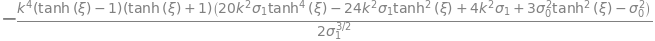

In [22]:
res = F1fda[1][1].subs(rp)\
  .subs({f1: ex1p, f2: ex1p}).doit().subs({x: xi/k - 2*k**2*t + 3*s0**2*t/(2*s1)}).combsimp()
display(res)
# print(latex(res))
# print(str(res).replace('sigma_', 's'))

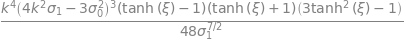

In [23]:
res = F1fda[2][1].subs(rp)\
  .subs({f1: ex1p, f2: ex1p}).doit().subs({x: xi/k - 2*k**2*t + 3*s0**2*t/(2*s1)}).combsimp()
display(res)
# print(latex(res))
# print(str(res).replace('sigma_', 's'))

\begin{equation}\label{Blin_eq71a}
 \phi^{(1)} = \phi^{(2)} = \dfrac{\sigma_0}{2 \sigma_1} - \dfrac{k}{\sqrt{\sigma_1}} \tanh\left(
k \left(\eta + \left(2 k^2 -\dfrac{3\sigma_0^2}{2\sigma_1}\right)  t\right) \right) ,
\end{equation}

In [24]:
ex1m = s0/(2*s1) - k/sqrt(s1)*tanh(k*x + k*(2*k**2 - 3*s0**2/(2*s1))*t)
display(ex1m)
display(F2fda[0][1].subs(rp)\
  .subs({f1: ex1m, f2: ex1m}).doit().simplify())

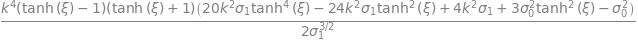

\frac{k^{4} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(20 k^{2} \sigma_{1} \tanh^{4}{\left(\xi \right)} - 24 k^{2} \sigma_{1} \tanh^{2}{\left(\xi \right)} + 4 k^{2} \sigma_{1} + 3 \sigma_{0}^{2} \tanh^{2}{\left(\xi \right)} - \sigma_{0}^{2}\right)}{2 \sigma_{1}^{\frac{3}{2}}}
k**4*(tanh(xi) - 1)*(tanh(xi) + 1)*(20*k**2*s1*tanh(xi)**4 - 24*k**2*s1*tanh(xi)**2 + 4*k**2*s1 + 3*s0**2*tanh(xi)**2 - s0**2)/(2*s1**(3/2))


In [25]:
res = F1fda[1][1].subs(rp)\
  .subs({f1: ex1m, f2: ex1m}).doit().subs({x: xi/k - 2*k**2*t + 3*s0**2*t/(2*s1)}).combsimp()
display(res)
print(latex(res))
print(str(res).replace('sigma_', 's'))

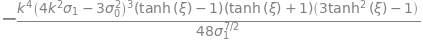

- \frac{k^{4} \left(4 k^{2} \sigma_{1} - 3 \sigma_{0}^{2}\right)^{3} \left(\tanh{\left(\xi \right)} - 1\right) \left(\tanh{\left(\xi \right)} + 1\right) \left(3 \tanh^{2}{\left(\xi \right)} - 1\right)}{48 \sigma_{1}^{\frac{7}{2}}}
-k**4*(4*k**2*s1 - 3*s0**2)**3*(tanh(xi) - 1)*(tanh(xi) + 1)*(3*tanh(xi)**2 - 1)/(48*s1**(7/2))


In [26]:
res = F1fda[2][1].subs(rp)\
  .subs({f1: ex1m, f2: ex1m}).doit().subs({x: xi/k - 2*k**2*t + 3*s0**2*t/(2*s1)}).combsimp()
display(res)
print(latex(res))
print(str(res).replace('sigma_', 's'))

# Если считать материал оболочки линейно-упругим 
с линейной зависимостью интенсивности напряжений $\sigma_i$
от интенсивности деформаций $e_i$ для $i$-ой цилиндрической оболочки:
\begin{equation}\label{sigma1}
\sigma_i=Ee_i .
\end{equation}
В результате для система уравнений в случае
геометрически нелинейных оболочек примет следующий вид:
\begin{equation}\label{Blin_eq7d}
  \begin{gathered}
    \phi_t^{(1)}+6\sigma_0\phi^{(1)}\phi_\eta^{(1)}+\phi_{\eta\eta\eta}^{(1)}+
      \phi^{(1)}-\phi^{(2)}=0,\\
    \phi_t^{(2)}+6\sigma_0\phi^{(2)}\phi_\eta^{(2)}+\phi_{\eta\eta\eta}^{(2)}+
      \phi^{(2)}-\phi^{(1)} - \sigma \phi^{(2)} =0.
  \end{gathered}
\end{equation} 

In [26]:
rp = {s1: 0, s: 0}
ex3 = 2*k**2/s0*(1 - tanh(k*(x - 4*k**2*t))**2)
display(ex3)
display(F2fda[0][1].subs(rp)\
  .subs({f1: ex3, f2: ex3}).doit().simplify())

In [27]:
res = F1fda[1][1].subs(rp)\
  .subs({f1: ex3, f2: ex3}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
# print(latex(res))
# print(str(res).replace('sigma_', 's'))

In [28]:
res = F1fda[2][1].subs(rp)\
  .subs({f1: ex3, f2: ex3}).doit().subs({x: xi/k + 4*k**2*t}).combsimp()
display(res)
# print(latex(res))
# print(str(res).replace('sigma_', 's'))